In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append('./helpers_models/')
sys.path.append('./data_visualization_and_augmentations/')
sys.path.append('../torch_videovision/')
sys.path.append('./important_csvs/')

from helpers_resnet import *

resnet = torchvision.models.resnet50(pretrained=True)
adaptive_pooling = AdaptiveConcatPool2d()
head = Head()
resnet.avgpool = adaptive_pooling
resnet.fc = head

os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

resnet = resnet.cuda()

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.avgpool.parameters():
    param.requires_grad = True
    
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = nn.DataParallel(resnet)
check_freeze(resnet.module)

conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 False
layer4 False
avgpool True
fc True


In [3]:
from helpers_thresholds import *

In [43]:
plt.rcParams['figure.figsize'] = (20,12)
font = {'family' : 'DejaVu Sans',  'weight' : 'normal',  'size'  : 24}
plt.rc('font', **font)

In [5]:
tensor_transform = get_tensor_transform('ImageNet', False)
train_spat_transform = get_spatial_transform(2)
train_temp_transform = get_temporal_transform(16)
valid_spat_transform = get_spatial_transform(0)
valid_temp_transform = va.TemporalFit(size=16)

root_dir = '/media/scratch/astamoulakatos/nsea_video_jpegs/'
df = pd.read_csv('./small_dataset_csvs/events_with_number_of_frames_stratified.csv')
# df_train = get_df(df, 20, True, False, False)
# class_image_paths, end_idx, idx_label= get_indices(df_train, root_dir)
# train_loader = get_loader(1, 128, end_idx, class_image_paths, train_temp_transform, train_spat_transform, tensor_transform, False, True, True, 1)
df_valid = get_df(df, 20, False, True, False)
class_image_paths, end_idx, idx_label = get_indices(df_valid, root_dir)
valid_loader = get_loader(20, 1, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, False, True, 1)
df_test = get_df(df, 20, False, False, True)
class_image_paths, end_idx, idx_label = get_indices(df_test, root_dir)
test_loader = get_loader(20, 1, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, False, True, 1)

torch.cuda.empty_cache()

In [6]:
load = True
if load:
    checkpoint = torch.load('/media/scratch/astamoulakatos/saved-resnet-models/fifth-small-aug-final/best-checkpoint-010epoch.pth')
    resnet.load_state_dict(checkpoint['model_state_dict'])
    print('loading pretrained freezed model!')

loading pretrained freezed model!


In [7]:
inputs, classes = next(iter(valid_loader))

In [8]:
inputs.shape

torch.Size([1, 3, 16, 576, 704])

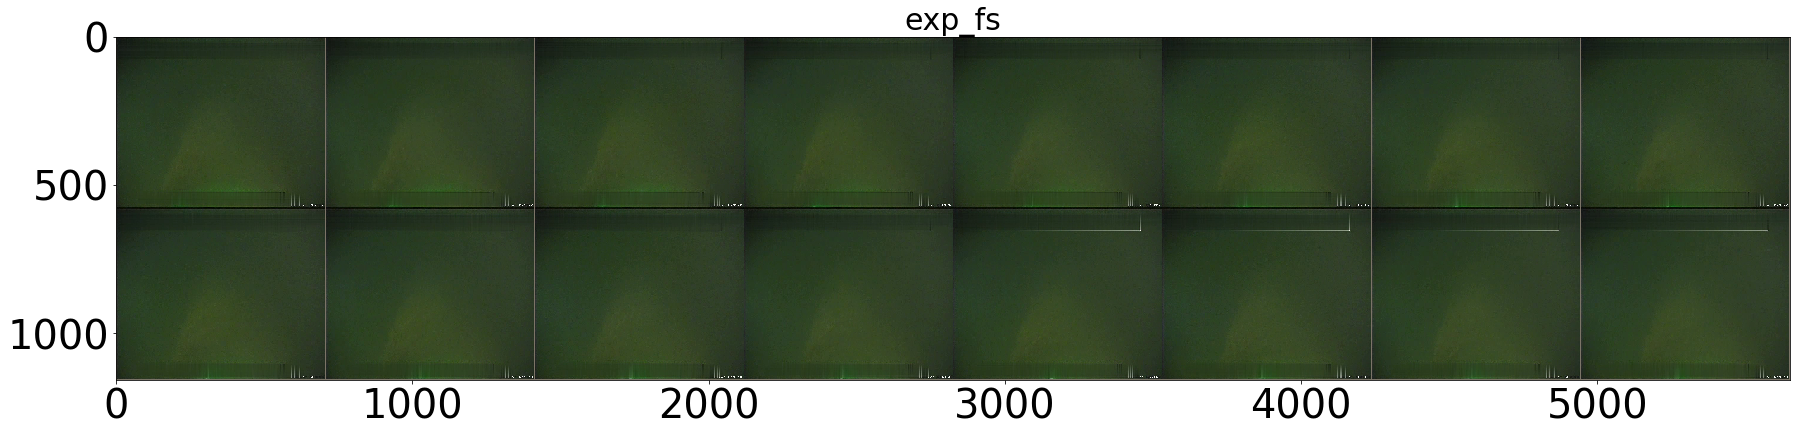

In [9]:
show_batch(valid_loader, 1)

In [10]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in valid_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output = resnet(X)
        y = y.detach().cpu()
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu()
        mean_preds = torch.mean(preds, dim=0)
        y_pred.append(mean_preds)
        y_true.append(y)
        


In [18]:
y_pred

[tensor([0.7970, 0.2497, 0.0159, 0.1954, 0.0250]),
 tensor([0.9866, 0.0093, 0.0049, 0.0031, 1.0000]),
 tensor([0.0437, 0.9449, 0.0392, 0.0443, 0.0034]),
 tensor([0.9684, 0.0351, 0.1773, 0.0584, 0.1103]),
 tensor([0.2549, 0.7185, 0.0339, 0.0655, 0.0116]),
 tensor([0.9909, 0.0128, 0.7307, 0.1298, 0.0080]),
 tensor([0.9785, 0.0247, 0.4002, 0.0360, 0.1265]),
 tensor([0.9832, 0.0215, 0.5684, 0.3054, 0.0127]),
 tensor([0.0539, 0.9357, 0.0077, 0.0043, 0.0115]),
 tensor([0.0629, 0.9280, 0.0067, 0.0062, 0.0115]),
 tensor([0.9113, 0.0985, 0.0238, 0.2684, 0.0239]),
 tensor([0.6709, 0.3585, 0.0179, 0.1936, 0.0101]),
 tensor([0.0489, 0.9376, 0.0297, 0.0373, 0.0034]),
 tensor([0.9904, 0.0064, 0.0062, 0.0059, 1.0000]),
 tensor([0.9887, 0.0141, 0.2724, 0.5962, 0.0094]),
 tensor([0.9628, 0.0390, 0.0754, 0.6365, 0.0523]),
 tensor([0.9941, 0.0035, 0.0061, 0.0038, 1.0000]),
 tensor([0.9949, 0.0082, 0.8054, 0.1315, 0.0058]),
 tensor([0.5063, 0.5026, 0.0272, 0.0769, 0.0201]),
 tensor([0.9945, 0.0032, 0.0054

In [19]:
y_true

[tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 1., 0.]),
 tensor([1., 0., 0., 1., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([1., 0., 0., 0., 0.]),
 tensor(

In [45]:
y_tr = np.vstack([tensor.__array__() for tensor in y_true])

In [46]:
y_pr = np.vstack([tensor.__array__() for tensor in y_pred]) 

In [47]:
y_tr

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [48]:
y_pr

array([[0.79699975, 0.2496971 , 0.01588666, 0.19538943, 0.02503364],
       [0.98657733, 0.00933939, 0.00493289, 0.00311406, 0.9999964 ],
       [0.04372386, 0.9449079 , 0.03920538, 0.04425135, 0.00338694],
       ...,
       [0.9856693 , 0.01828046, 0.15714245, 0.25828445, 0.04615556],
       [0.9957338 , 0.00229248, 0.00396537, 0.00214662, 1.        ],
       [0.9529356 , 0.04691991, 0.43288887, 0.19806948, 0.02534134]],
      dtype=float32)

In [49]:
from helpers_thresholds import *

In [50]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

0.8729631864815932 0.9140600315955766 0.8930390492359933
Optimal  Exposure  Threshold =  0.7329053

0.9817351598173516 0.7253012048192771 0.8342572062084258
Optimal  Burial  Threshold =  0.0992621

0.9733333333333334 0.6083333333333333 0.7487179487179488
Optimal  Field Joint  Threshold =  0.14337364

0.5201793721973094 0.8992248062015504 0.6590909090909091
Optimal  Anode  Threshold =  0.38669473

1.0 1.0 1.0
Optimal  Free Span  Threshold =  0.28453067



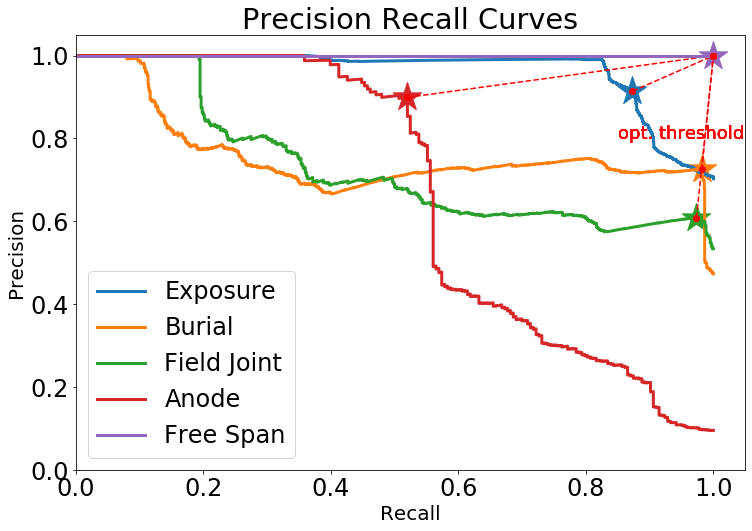

In [51]:
plot_pr_curves(0.0, y_tr, y_pr, classes, '_2d_rolling_avg')

In [53]:
thresholds = nsea_compute_thresholds(y_tr, y_pr, classes)

In [54]:
thresholds

{'Exposure': 0.7329053,
 'Burial': 0.0992621,
 'Field Joint': 0.14337364,
 'Anode': 0.38669473,
 'Free Span': 0.28453067}

In [55]:
df_thresholds = pd.DataFrame({'Threshold': thresholds}).T
df_thresholds

,Anode,Burial,Exposure,Field Joint,Free Span
Threshold,0.386695,0.099262,0.732905,0.143374,0.284531


# Table 1

In [56]:
print(df_thresholds.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{lrrrrr}
\toprule
{} &  Anode &  Burial &  Exposure &  Field Joint &  Free Span \\
\midrule
Threshold &  0.386 &   0.099 &     0.732 &        0.143 &      0.284 \\
\bottomrule
\end{tabular}



## validation set

In [57]:
result_valid = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [58]:
result_valid

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.732905,0.857025,0.914060,0.872963,0.893039,1261.0,272.0,421.0,2893.0
1,Burial,0.099262,0.876625,0.725301,0.981735,0.834257,2744.0,570.0,28.0,1505.0
2,Field Joint,0.143374,0.919125,0.608333,0.973333,0.748718,3871.0,376.0,16.0,584.0
3,Anode,0.386695,0.975242,0.899225,0.520179,0.659091,4611.0,13.0,107.0,116.0
4,Free Span,0.284531,1.000000,1.000000,1.000000,1.000000,3040.0,0.0,0.0,1807.0
5,Aggregate,NaN,0.755313,0.836290,0.899835,0.857795,NaN,NaN,NaN,NaN


In [59]:
print(result_valid.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &        Event &  Threshold &  Exact Matching Score &  Precision &  Recall &  F1-Score &       tn &      fp &      fn &       tp \\
\midrule
0 &     Exposure &      0.732 &                 0.857 &      0.914 &   0.872 &     0.893 & 1261.000 & 272.000 & 421.000 & 2893.000 \\
1 &       Burial &      0.099 &                 0.876 &      0.725 &   0.981 &     0.834 & 2744.000 & 570.000 &  28.000 & 1505.000 \\
2 &  Field Joint &      0.143 &                 0.919 &      0.608 &   0.973 &     0.748 & 3871.000 & 376.000 &  16.000 &  584.000 \\
3 &        Anode &      0.386 &                 0.975 &      0.899 &   0.520 &     0.659 & 4611.000 &  13.000 & 107.000 &  116.000 \\
4 &    Free Span &      0.284 &                 1.000 &      1.000 &   1.000 &     1.000 & 3040.000 &   0.000 &   0.000 & 1807.000 \\
5 &    Aggregate &        nan &                 0.755 &      0.836 &   0.899 &     0.857 &      nan &     nan &     nan &      nan \\
\bottomrule
\e

In [60]:
acc, f1 = compute_label_metrics(y_tr, y_pr, 0.5, classes)

In [61]:
acc

array([0.85702496, 0.87662472, 0.91912523, 0.97524242, 1.        ])

In [62]:
f1

array([0.89303905, 0.83425721, 0.74871795, 0.65909091, 1.        ])

## test set

In [63]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output = resnet(X)
        y = y.detach().cpu()
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu()
        mean_preds = torch.mean(preds, dim=0)
        y_pred.append(mean_preds)
        y_true.append(y)
        


In [64]:
y_tr = np.vstack([tensor.__array__() for tensor in y_true])

In [65]:
y_pr = np.vstack([tensor.__array__() for tensor in y_pred]) 

In [66]:
result_test = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [67]:
result_test

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.732905,0.888911,0.903522,0.922452,0.912889,1555.0,315.0,248.0,2950.0
1,Burial,0.099262,0.837806,0.734138,0.878610,0.799903,2603.0,595.0,227.0,1643.0
2,Field Joint,0.143374,0.847672,0.401619,0.937618,0.562358,3800.0,739.0,33.0,496.0
3,Anode,0.386695,0.957380,0.754098,0.446602,0.560976,4714.0,45.0,171.0,138.0
4,Free Span,0.284531,0.994475,0.982769,1.000000,0.991310,3443.0,28.0,0.0,1597.0
5,Aggregate,NaN,0.720994,0.817351,0.895916,0.843199,NaN,NaN,NaN,NaN


In [68]:
print(result_test.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &        Event &  Threshold &  Exact Matching Score &  Precision &  Recall &  F1-Score &       tn &      fp &      fn &       tp \\
\midrule
0 &     Exposure &      0.732 &                 0.888 &      0.903 &   0.922 &     0.912 & 1555.000 & 315.000 & 248.000 & 2950.000 \\
1 &       Burial &      0.099 &                 0.837 &      0.734 &   0.878 &     0.799 & 2603.000 & 595.000 & 227.000 & 1643.000 \\
2 &  Field Joint &      0.143 &                 0.847 &      0.401 &   0.937 &     0.562 & 3800.000 & 739.000 &  33.000 &  496.000 \\
3 &        Anode &      0.386 &                 0.957 &      0.754 &   0.446 &     0.560 & 4714.000 &  45.000 & 171.000 &  138.000 \\
4 &    Free Span &      0.284 &                 0.994 &      0.982 &   1.000 &     0.991 & 3443.000 &  28.000 &   0.000 & 1597.000 \\
5 &    Aggregate &        nan &                 0.720 &      0.817 &   0.895 &     0.843 &      nan &     nan &     nan &      nan \\
\bottomrule
\e

In [69]:
precision, recall, f1, _ = precision_recall_fscore_support(y_tr, y_pr)